<a href="https://colab.research.google.com/github/aakarsh7599/Text-Detection-using-Detectron2/blob/master/Text_Identification_using_Detectron_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Detection with Detectron 2 using a Custom Dataset**

**Detectron2** is a research platform and a production library for object detection, built by **Facebook AI Research (FAIR)**.

It is completely written on PyTorch and is flexible and extensible, and able to provide fast training on single or multiple GPU servers. 

Also, it includes high-quality implementations of state-of-the-art object detection algorithms, including 
**DensePose**
, 
**panoptic feature pyramid network**s
, and numerous variants of the pioneering 
**Mask R-CNN**
model family also developed by FAIR. 

Its extensible design makes it easy to implement cutting-edge research projects without having to fork the entire codebase.


**In this notebook, we are going to deal with identifying the language of text using the Faster RCNN model from the Detectron 2's model zoo.**

We are going to limit our languages by 2.



We identify **Hindi** and **English** Text and we include a Single Class called **Others** for other languages.



 
**Object Detection**

Locate the presence of objects with a bounding box and types or classes of the located objects in an image.


Input: An image with one or more objects, such as a photograph.


Output: One or more bounding boxes (e.g. defined by a point, width, and height), and a class label for each bounding box.

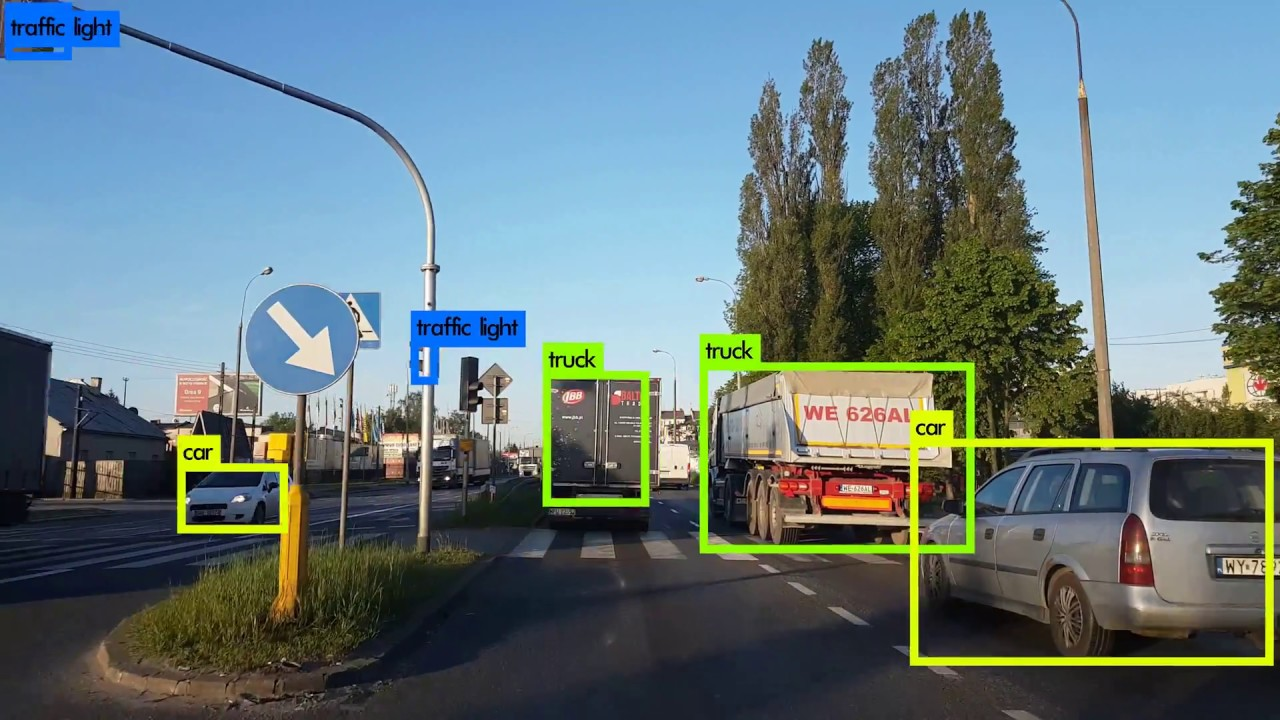

**Convolutional Neural Networks**


## Convolutional Neural Networks


**Deep Neural Networks**: Traditional Neural Networks are string of neurons connected together. 

It has the: Input layer, Hidden Layers, Output layer.

The input flows from the Input layer to the Output layer through the hidden layers.

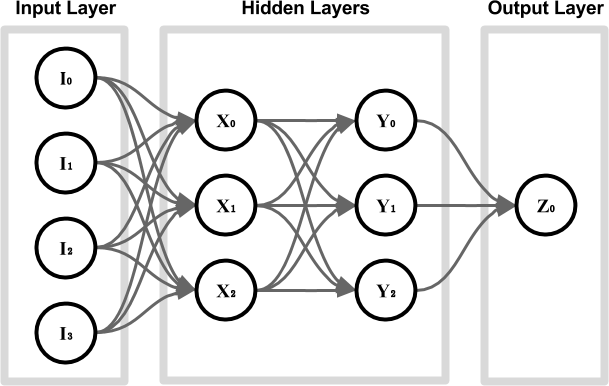

**Kernel Convolution**: A process where we take a small grid of numbers & pass them over the whole image transforming it. By using different numbers we can form blurs, edge detection, sharpen etc.,

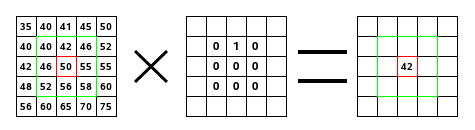

**Convolutional Neural Networks**
CNN's combine traditional Neural Networks and Convolutions.

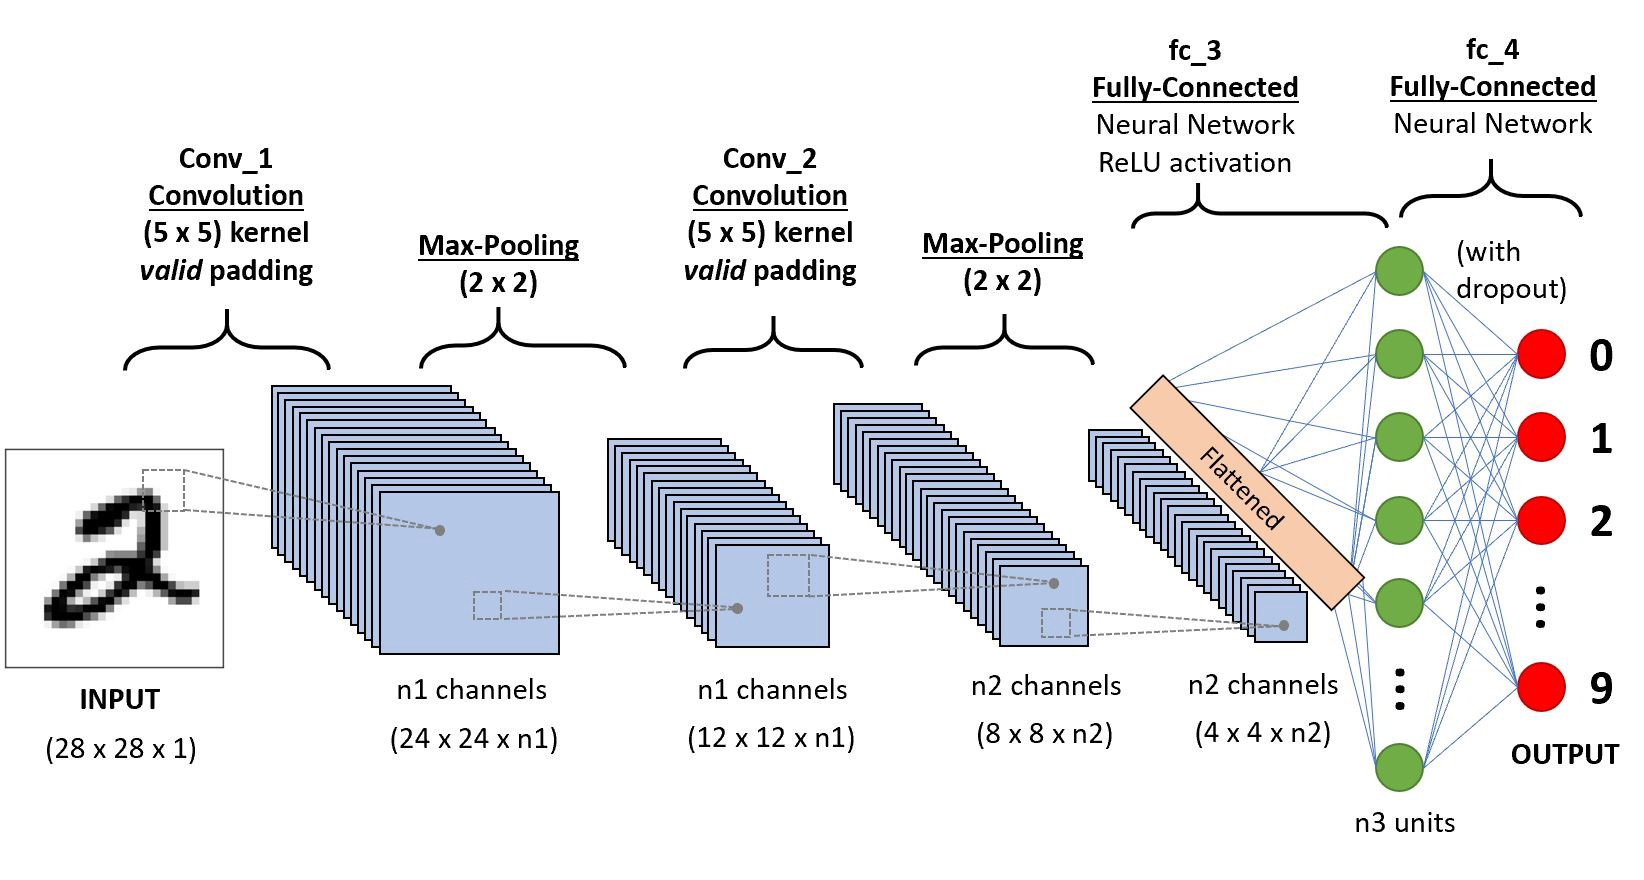






In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**R-CNN**

R-CNN (Girshick et al., 2014) is short for “Region-based Convolutional Neural Networks”. The main idea is composed of two steps. First, using selective search, it identifies a manageable number of bounding-box object region candidates (“region of interest” or “RoI”). And then it extracts CNN features from each region independently for classification.

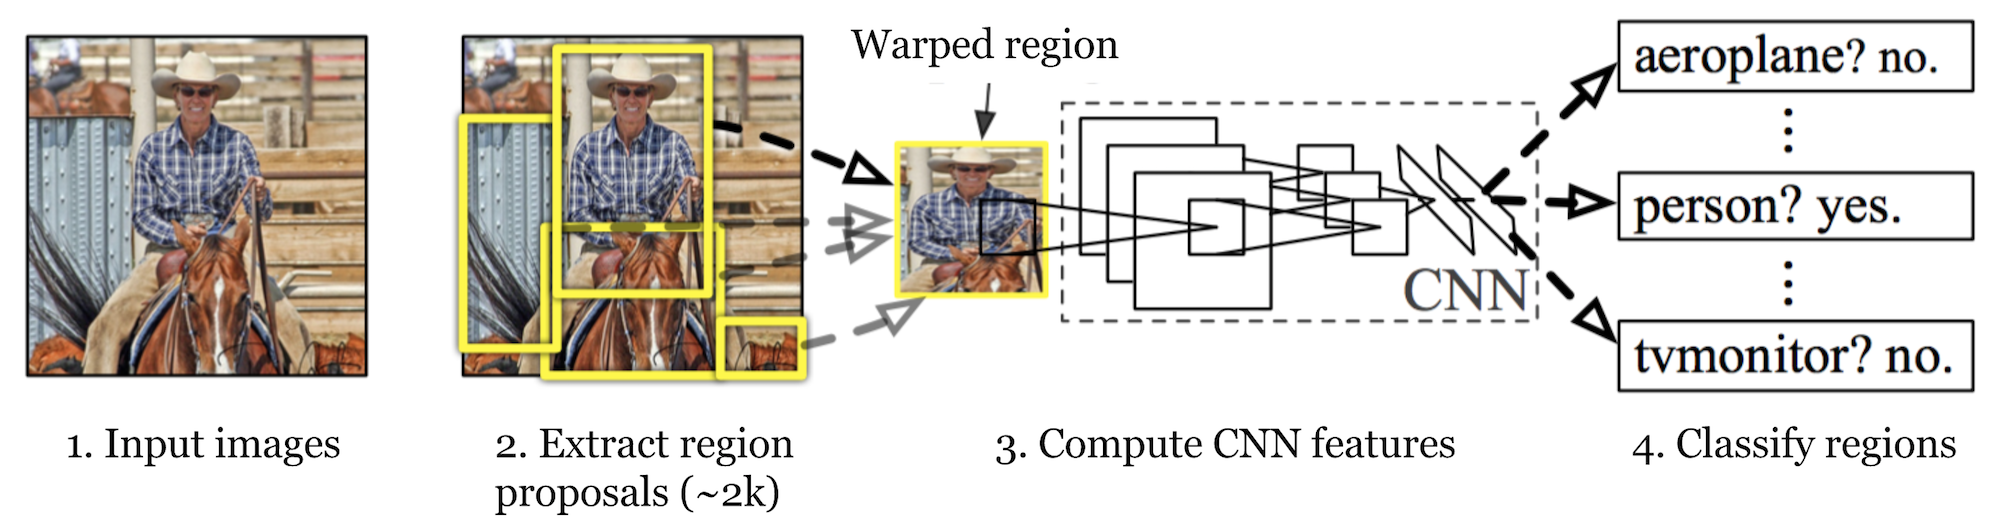

In [17]:
#If you did upload the zip file to your session storage, use this command or else modify accordingly.
!ls

!unzip "Text_Detection_Dataset_COCO_Format.zip"

drive	     Text_Detection_Dataset_COCO_Format
sample_data  Text_Detection_Dataset_COCO_Format.zip
Archive:  Text_Detection_Dataset_COCO_Format.zip
replace Text_Detection_Dataset_COCO_Format/train/0.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Text_Detection_Dataset_COCO_Format/train/0.jpeg  
replace Text_Detection_Dataset_COCO_Format/train/1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Text_Detection_Dataset_COCO_Format/train/1.jpeg  
replace Text_Detection_Dataset_COCO_Format/train/10.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Text_Detection_Dataset_COCO_Format/train/10.jpeg  
replace Text_Detection_Dataset_COCO_Format/train/100.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Text_Detection_Dataset_COCO_Format/train/101.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## **Install Dependencies**

Kickstart with installing a few dependencies such as Torch Vision and COCO API and check whether Cuda is available. Cuda helps in keeping track of the currently selected GPU.

In [18]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-e9zd7wyv
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-e9zd7wyv
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## **Install Detectron2**

 And then install Detectron2

In [19]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


Import a few necessary packages.

In [20]:
# You may need to restart your runtime prior to this, to let your installation take effect
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## **Preparing and registering the Dataset**



There are different types for the format of bbox. It must be a member of structures.BoxMode.There are 5 such formats. But, currently it supports: **BoxMode.XYXY_ABS, BoxMode.XYWH_ABS**. We use the second format and mention the same in our dataset. After that, we need to register our datset.

**DatasetCatalog**

To let detectron2 know how to obtain a dataset named “my_dataset”, users need to implement a function that returns the items in your dataset and then tell detectron2 about this function by using the method register.

**Metadata for a Dataset**

Each dataset is associated with some metadata, accessible through MetadataCatalog.get(dataset_name).some_metadata. 

- Metadata is a key-value mapping that contains information that’s shared among the entire dataset, and usually is used to interpret what’s in the dataset, e.g., names of classes, colors of classes, root of files, etc. 
- This information will be useful for augmentation, evaluation, visualization, logging, etc. The structure of metadata depends on what is needed from the corresponding downstream code.

In [64]:
import json
from detectron2.structures import BoxMode
def get_board_dicts(imgdir):
    imgdir= 'Text_Detection_Dataset_COCO_Format' +"/"+imgdir.split('Text_Detection_Dataset_COCO_Format')[1]
    print(imgdir)
    json_file = imgdir+"/dataset.json"
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
        filename = i["file_name"] 
        i["file_name"] = imgdir+"/"+filename 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS
            j["category_id"] = int(j["category_id"])
    return dataset_dicts
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("boardetect_" + d, lambda d=d: get_board_dicts("Text_Detection_Dataset_COCO_Format/" + d))
    MetadataCatalog.get("boardetect_" + d).set(thing_classes=["HINDI","ENGLISH","OTHER"])
board_metadata = MetadataCatalog.get("boardetect_train")

AssertionError: ignored

## **Visualizing the Training Dataset**

We'll now try to visualize the training dataset. We'll randomly pick 3 pictures from the train folder of our dataset and see how the bounding boxes look like.

**Visualizer**

Visualizer that draws data about detection/segmentation on images.

It contains methods like `draw_{text,box,circle,line,binary_mask,polygon}`
that draw primitive objects to images, as well as high-level wrappers like
`draw_{instance_predictions,sem_seg,panoptic_seg_predictions,dataset_dict}`
that draw composite data in some pre-defined style.

Text_Detection_Dataset_COCO_Format//train
{'image_id': 181, 'file_name': 'Text_Detection_Dataset_COCO_Format//train/181.jpeg', 'height': 500, 'width': 715, 'annotations': [{'bbox': [39, 1, 278, 158], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [339, 54, 164, 188], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [172, 407, 122, 67], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [298, 417, 210, 80], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}]}


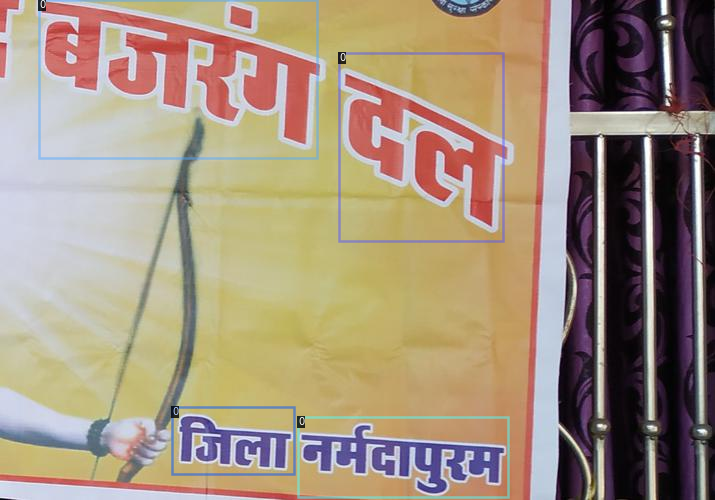

{'image_id': 135, 'file_name': 'Text_Detection_Dataset_COCO_Format//train/135.jpeg', 'height': 538, 'width': 956, 'annotations': [{'bbox': [258, 133, 449, 104], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [217, 236, 495, 70], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [199, 313, 262, 18], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}]}


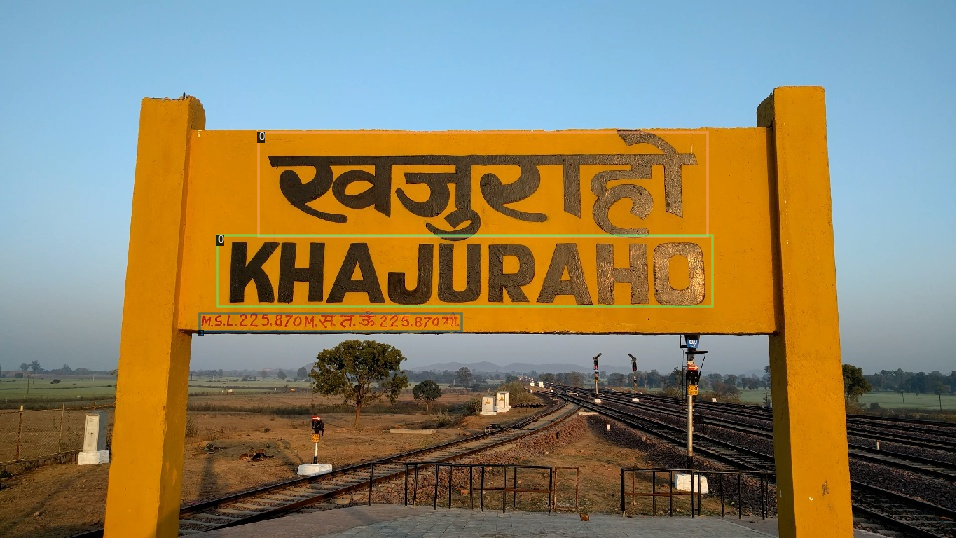

{'image_id': 260, 'file_name': 'Text_Detection_Dataset_COCO_Format//train/260.jpeg', 'height': 500, 'width': 715, 'annotations': [{'bbox': [11, 268, 41, 35], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [61, 272, 109, 26], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [177, 267, 89, 29], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [278, 263, 56, 29], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [340, 264, 50, 26], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [397, 262, 60, 28], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [470, 261, 54, 26], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [532, 261, 48, 24], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [590, 255, 98, 37], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [11, 317, 55, 29], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [76, 309, 143, 32], 'bb

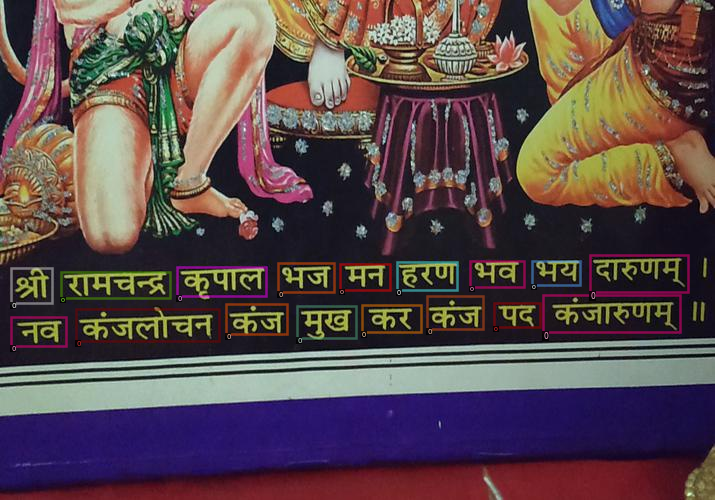

In [52]:
from detectron2.data.catalog import Metadata
dataset_dicts=get_board_dicts("Text_Detection_Dataset_COCO_Format/train")
for d in random.sample(dataset_dicts,3):
  print(d)
  img=cv2.imread(d['file_name'])
  visualizer = Visualizer(img[:,:,::-1],metadata=board_metadata)
  vis=visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:,:,::-1])

## **Training the Faster R-CNN Model**

We now have a custom model and a data loader. To run training, users typically have a preference in one of the following **two** styles:

**Custom Training Loop**

With a model and a data loader ready, everything else needed to write a training loop can be found in PyTorch, and you are free to write the training loop yourself. This style allows researchers to manage the entire training logic more clearly and have full control. One such example is provided in tools/plain_train_net.py.

Any customization on the training logic is then easily controlled by the user.

**Trainer Abstraction**

We also provide a standarized “trainer” abstraction with a hook system that helps simplify the standard training behavior. It includes the following two instantiations:


- **SimpleTrainer** provides a minimal training loop for single-cost single-optimizer single-data-source training, with nothing else. Other tasks (checkpointing, logging, etc) can be implemented using the hook system.


- **DefaultTrainer** is a SimpleTrainer initialized from a config, used by tools/train_net.py and many scripts. It includes more standard default behaviors that one might want to opt in, including default configurations for optimizer, learning rate schedule, logging, evaluation, checkpointing etc.


**To customize a DefaultTrainer:**


For simple customizations (e.g. change optimizer, evaluator, LR scheduler, data loader, etc.), overwrite its methods in a subclass.

We will look at an example of changing the evaluator.

**Hook System**

For extra tasks during training, check the hook system to see if it’s supported.

As an example, to print hello during training:


class HelloHook(HookBase):
  def after_step(self):
    if self.trainer.iter % 100 == 0:
      print(f"Hello at iteration {self.trainer.iter}!")


Using a trainer+hook system means there will always be some non-standard behaviors that cannot be supported, especially in research. For this reason, we intentionally keep the trainer & hook system minimal, rather than powerful. If anything cannot be achieved by such a system, it’s easier to start from tools/plain_train_net.py to implement custom training logic manually.

In [57]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

This is the step where we set the configuration for training. Everything related to hyperparameters and parameters related to normalization must be defined here.

**Learning Rate**   
Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0. The learning rate controls how quickly the model is adapted to the problem.


**Iteration** is one time processing for forward and backward for a batch of images (say one batch is defined as 16, then 16 images are processed in one iteration). 

**Epoch** is once all images are processed one time individually of forward and backward to the network, then that is one epoch.

**ROI_HEADS - BATCH_SIZE_PER_IMAGE** parameter is used to sample a subset of proposals coming out of RPN (Region Proposed Network) to calculate cls and reg loss during training. Calculating loss on all RPN proposals isn't computationally efficient.

**Evaluation Period** 
To set the number of iterations to perform evaluation on the cfg.DATASETS.TEST, which should be our Validation set.

For example: Setting EVAL_PERIOD = 100, This will do evaluation once after 100 iterations on the cfg.DATASETS.TEST, which should be our Validation set.


We use the **"faster_rcnn_R_50_FPN_3x.yaml"** model from the model zoo of the Detectron2.

In [43]:
cfg.DATASETS.TRAIN

('train',)

In [59]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("boardetect_train",)
cfg.DATASETS.TEST = ("boardetect_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # No. of classes = [HINDI, ENGLISH, OTHER]
cfg.TEST.EVAL_PERIOD = 500
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/13 20:24:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[06/13 20:24:31 d2.engine.train_loop]: Starting training from iteration 0
[06/13 20:24:50 d2.utils.events]:  eta: 0:23:58  iter: 19  total_loss: 1.966  loss_cls: 1.003  loss_box_reg: 0.487  loss_rpn_cls: 0.268  loss_rpn_loc: 0.054  time: 0.9546  data_time: 0.0417  lr: 0.000250  max_mem: 9204M
[06/13 20:25:10 d2.utils.events]:  eta: 0:23:52  iter: 39  total_loss: 1.401  loss_cls: 0.562  loss_box_reg: 0.721  loss_rpn_cls: 0.056  loss_rpn_loc: 0.074  time: 0.9753  data_time: 0.0168  lr: 0.000500  max_mem: 9204M
[06/13 20:25:30 d2.utils.events]:  eta: 0:24:00  iter: 59  total_loss: 1.272  loss_cls: 0.441  loss_box_reg: 0.679  loss_rpn_cls: 0.059  loss_rpn_loc: 0.091  time: 0.9871  data_time: 0.0154  lr: 0.000749  max_mem: 9204M
[06/13 20:25:50 d2.utils.events]:  eta: 0:23:45  iter: 79  total_loss: 1.057  loss_cls: 0.365  loss_box_reg: 0.601  loss_rpn_cls: 0.032  loss_rpn_loc: 0.043  time: 0.9905  data_time: 0.0166  lr: 0.000999  max_mem: 9204M
[06/13 20:26:09 d2.utils.events]:  eta: 0:23:2

Using this, you can analyze how your training was progressed over time. 

## **Inference from the Validation Dataset using the trained model**

An output folder gets saved in the local storage in which the final weights are stored. You can save this folder for inferencing from this model in future.

Set the score threshold value for reducing the redundant boxes on the prediction results.

**Default Predictor**

Create a simple end-to-end predictor with the given config that runs on single device for a single input image.

In [60]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
cfg.DATASETS.TEST = ("boardetect_val", )
predictor = DefaultPredictor(cfg)

Text_Detection_Dataset_COCO_Format//val


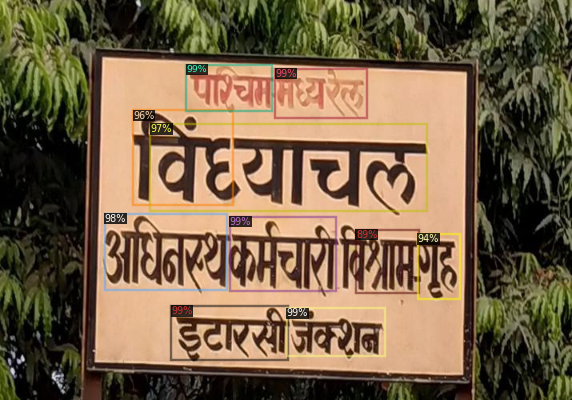

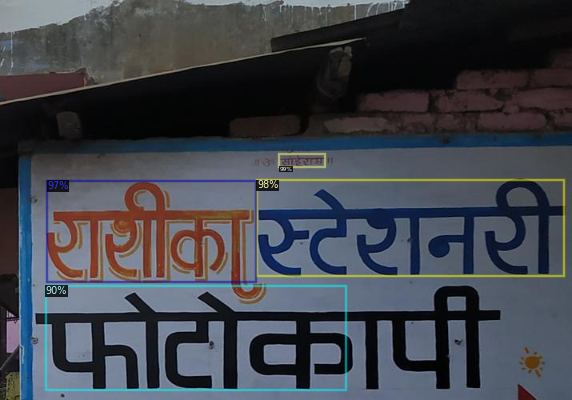

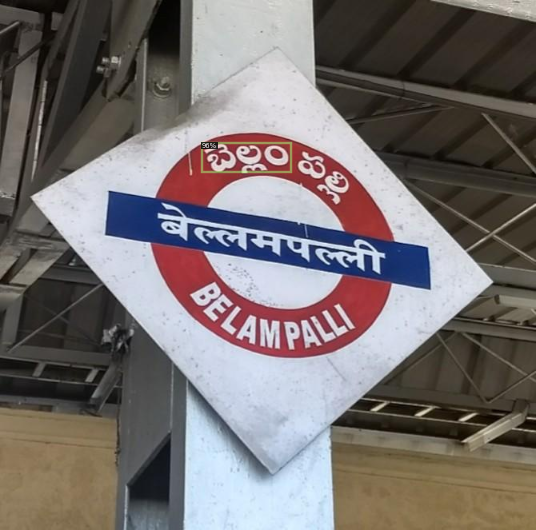

In [62]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_board_dicts("/Text_Detection_Dataset_COCO_Format/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=board_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


## **Evaluating the model**

In [66]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("boardetect_val", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "boardetect_val")
inference_on_dataset(predictor.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

Text_Detection_Dataset_COCO_Format/val
[06/13 20:52:55 d2.data.common]: Serializing 27 elements to byte tensors and concatenating them all ...
[06/13 20:52:55 d2.data.common]: Serialized dataset takes 0.01 MiB
[06/13 20:52:55 d2.evaluation.evaluator]: Start inference on 27 images
[06/13 20:52:57 d2.evaluation.evaluator]: Inference done 11/27. 0.1074 s / img. ETA=0:00:01
[06/13 20:52:59 d2.evaluation.evaluator]: Total inference time: 0:00:02.477241 (0.112602 s / img per device, on 1 devices)
[06/13 20:52:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.105789 s / img per device, on 1 devices)
[06/13 20:52:59 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/13 20:52:59 d2.evaluation.coco_evaluation]: Saving results to /output/coco_instances_results.json
[06/13 20:52:59 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...

OrderedDict([('bbox',
              {'AP': 29.32953945301955,
               'AP-english': 38.73696221688374,
               'AP-hindi': 49.2516561421749,
               'AP-other': 0.0,
               'AP50': 50.20645415477376,
               'AP75': 29.295090534141494,
               'APl': 23.34257173081257,
               'APm': 48.75098483628216,
               'APs': 38.65040075436115})])

Usually the model is evaluated following the COCO Standards of evaluation. Mean Average Precision (mAP) is used to evaluate the performance of the model.

**Inference on Dataset**

The function inference_on_dataset() runs the model over all samples in the dataset, and have a DatasetEvaluator to process the inputs/outputs.

**Build Detection Test Loader**

Build a dataloader for object detection with some default features. This interface is experimental.

**Intersection over Union (IoU)**

The IoU is given by the ratio of the area of intersection and area of union of the predicted bounding box and ground truth bounding box.

The IoU would be used to determine if a predicted bounding box (BB) is TP, FP or FN. The TN is not evaluated as each image is assumed to have an object in it.

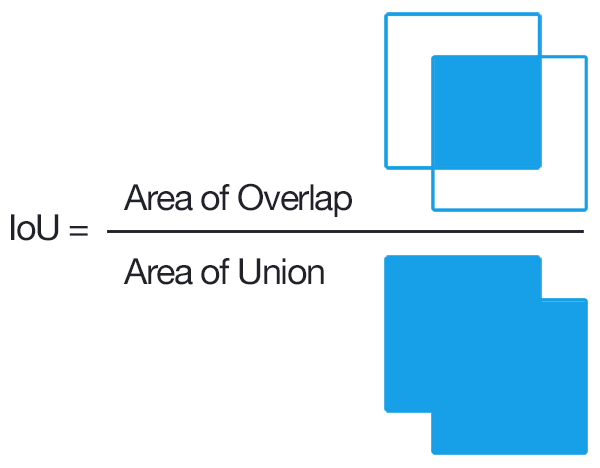

IoU metric ranges from **0 and 1** with 0 signifying no overlap and 1 implying perfect overlap between ground truth and prediction.

With IoU metric we need to define a threshold (α, say) that is used to distinguish a valid detection from the one which is not.

We can, therefore, redefine **TP (correct detection)** as a detection for which
IoU≥ α and **FP (invalid detection)** with IoU< α. **FN** is a ground-truth missed by the model.


**Precision and Recall**

Precision is the ability of a classifier to identify relevant objects only. It is the proportion of true positive detections.
Recall, on the other hand, measures the ability of the model to find all relevant cases (that is, all ground-truths) — the proportion of true positives detected among all ground-truths.

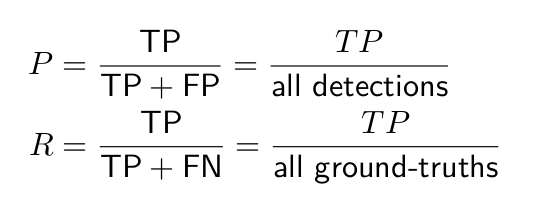

**Average precision** computes the average precision value for recall value over 0 to 1.
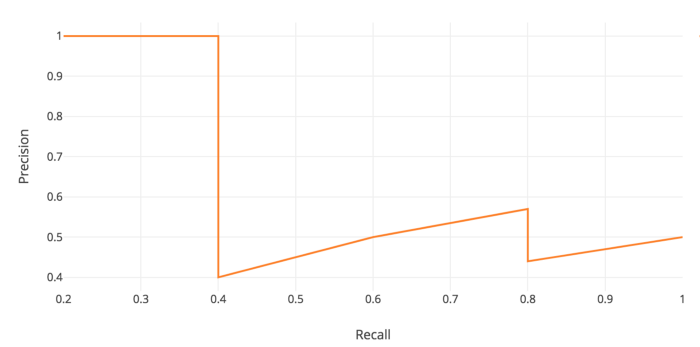

The general definition for the Average Precision (AP) is finding the area under the precision-recall curve above.